In [2]:
import numpy as np
from scipy.integrate import simps
from scipy.integrate import quad
import pandas as pd 
import del_m_fisher_bias_full as m  # CHECK WHICH D0,D1 IS USED
import numpy as np
#import fisher_ayan_function as f
#import dmdtheta_ayan_function as dm
#import fisher_ayan_function_LSST as f
#import fisher_ayan_function_LSST_CMBPrior as f
import sys
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse
import matplotlib as mpl
import matplotlib.pyplot as plt
#import Fisher_Ellipse_LSST_CMBPrior as F
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from copy import copy

In [146]:
b = pd.read_csv('interpolated_new_3.csv',sep =' ' ) 
b_old = pd.read_csv('interpolated_new_2.csv',sep =' ' ) 
#b = pd.read_csv('interpolated_error.csv',sep =' ' )

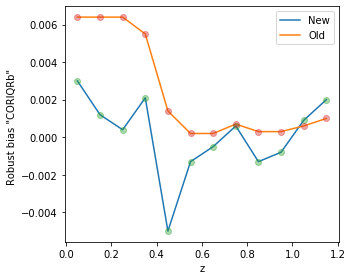

In [154]:
plt.rcParams['figure.figsize'] = [5,4] 
plt.plot(b.z,b.bias,label='New')
plt.plot(b.z,b_old.bias,label='Old')
plt.plot(b.z,b.bias,'o',alpha=0.4,label='_nolegend_')
plt.plot(b.z,b_old.bias,'o',alpha=0.4,label='_nolegend_')
plt.xlabel('z')
plt.ylabel('Robust bias "CORIQRb" ' )
plt.legend()
plt.tight_layout()
plt.savefig('CORIQR/comparison.pdf',bbox_inches='tight')

In [122]:
b.bias = b.bias/6.

Text(0, 0.5, 'Robust bias "CORIQRb" ')

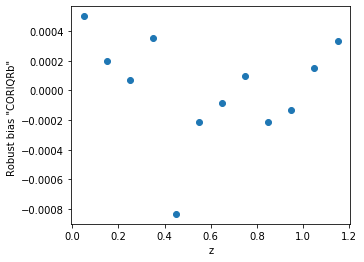

In [123]:
plt.rcParams['figure.figsize'] = [5,4] 
plt.plot(b.z,b.bias,'o')
plt.xlabel('z')
plt.ylabel('Robust bias "CORIQRb" ' )
#plt.legend()

#### For SN Ia , the magnitude is given by 
### $m=5\log_{10}\left[H_0D_L(z)\right]$ + $M$
#### And the derived dark energy cosmology, mentioned above is parametrised by the CPL dark energy parametrisation :
### $w(z)=w_0+w_a\frac{z}{1+z}$

#### The first step is to locate the parameters $\theta$ on which we want to base our Covariance maitrx or the Fisher matrix. Then we need to compute the partial derivatives w.r.t. $\theta$ for the observable which is magnitude in case of a SN Ia.

# $\frac{dm}{d\theta}$
# $\theta$ = $\{M,m,w_0,w_a\}$

#### Till this point, all we need to know is the :
#### (1) Model observable $m$
#### (2) Fisher parameters $\theta$

In [124]:
Om = 0.3  # Omega Matter
Omatter = (1-Om)
w0 = -1
wa = 0
#w0 = -1.2;wa = -0.9;
#w0 = -0.8;wa = 0.9;
#a = (1+z)**(-1)
# 1
print ('w0, wa used : ', w0, wa)
# Not Required
#---------------------------------

def X(z):
    a = (1+z)**(-1)
    return Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))


def dxdm(z, wa, w0):
    a = (1+z)**(-1)
    zt = (1+z)
    w = (wa+w0)
    X3 = np.exp(3*wa*(a-1))
    X2 = zt**(3*w)
    X1 = X2*X3
    X4 = 1.-X1
    X = Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
    A = (X**(-1.5))*X4*(zt**3)
    #A  = [1-zt**(-3*w)*np.exp(-3*wa*z/zt)]*zt**3
    return A

# 2


def dxdw0(z, wa, w0):
    a = (1+z)**(-1)
    zt = (1+z)
    ztt = z/zt  # z/1+z
    a_a = a**(3*wa)
    a_0 = a**(3*w0)
    e_a = np.exp(3*wa*(-ztt))
    A3 = (a_a**-1)*(-3*np.log(a)/a_0)
    A4 = e_a*A3
    X = Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
    A = (X**(-1.5))*Omatter*zt**3*(A4)
    return A


# 3
def dxdwa(z, wa, w0):
    a = (1+z)**(-1)
    a2 = a-1
    zt = (1+z)
    ztt = z/zt
    a_a = a**(3*wa)
    a_0 = a**(3*w0)
    e_a = np.exp(3*wa*(-ztt))
    A3 = e_a*(-3*np.log(a)/a_a)
    A2 = 3*(a-1)*e_a/(a_a)
    A4 = A2+A3
    X = Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
    A = (X**(-1.5))*(Omatter)*(zt**3)*(a_0**-1)*(A4)
    return A

# dxdM = 1 

# PRINTING CHECKS
#print 'Redshift  dx/dm      dx/dwo      dx/dwa'
#print '---------------------------------------'
# for i in (np.linspace(0.05,1.65,17)):
#          print("%.4f    %.4f    %.4f     %.4f " %(i,dxdm(i,0,-1),dxdw0(i,0,-1),dxdwa(i,0,-1)) )
# ************************************************************
# ************************************************************


# Integration Part : STARTS FROmatter BELOW

def H_0D_L(z):  # THIS WILL BE THEN INTEGRATED IN LINE NO. 106
    a = (1+z)**(-1)
    sec = (1-Om)*(a**-3)*(a**(-3*(w0+wa))*np.exp(3*(wa*(a-1))))
    fir = (Om*(a**-3))
    return((fir+sec)**(-0.5))


# ADDITIONAL FUNCTION DECLARATION
def fu1(z):
    return dxdm(z, wa, w0)


def fu2(z):
    return dxdw0(z, wa, w0)


def fu3(z):
    return dxdwa(z, wa, w0)

w0, wa used :  -1 0


In [125]:
# Z BINS
z = np.array(b.z)
#z = np.linspace(0.15,1.15,12)

# VARIABLE DECLARATION
I_om = []
I_wa = []
I_wo = []
hdl = []
prefactor1 = []
dx_domega = []
dx_dwa = []
dx_dw0 = []

# INTEGRATIONS RUNNING FROM LIMIT [0,Z_BIN[i]]
# THE fu FUNCTION CALLS THE OTHER FUNCTION : DX/DTHETA
# QUAD IS A PYTHON INTEGRATION FUNCTION WITH 3 ARGUMENTS :
# FUNCTION TO INTEGRATE, LOWER LIMIT, UPPER LIMIT

for ii in range(len(z[:])):
    I_om.append(quad(fu1, 0, z[ii])[0])
    I_wo.append(quad(fu2, 0, z[ii])[0])
    I_wa.append(quad(fu3, 0, z[ii])[0])
    hdl.append((1+z[ii])*quad(H_0D_L, 0, z[ii])[0])  # H0_Dl INTEGRATION
    # PREFACTOR WITHOUT THE H0_Dl TERM. THE 1* STANDS FOR 'c'
    prefactor1.append((-5/np.log(10))*(1*(1+z[ii]))/2)


# STORING THE VALUES IN ARRAYS
for i in range(len(I_om)):
    dx_domega.append((prefactor1[i]/hdl[i])*I_om[i])
    dx_dw0.append((prefactor1[i]/hdl[i])*I_wo[i])
    dx_dwa.append((prefactor1[i]/hdl[i])*I_wa[i])
    dx_dM = np.ones(17)
# WRITING TO A FILE
DXDT = pd.DataFrame(zip(z, dx_domega, dx_dw0, dx_dwa, dx_dM))
DXDT.columns = ['z', 'dmdom', 'dmdwo', 'dmdwa', 'dmdM']
DXDT.to_csv('Fisher_Table_LSST.csv', index=False)

def func():
    return DXDT

In [126]:
z

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15])

# Fisher_function with CMB Prior for LSST
#### fisher_ayan_function_LSST_CMBPrior.py

In [127]:
DXDT

,z,dmdom,dmdwo,dmdwa,dmdM
0,0.05,-0.081321,-0.054186,-0.000869,1.0
1,0.15,-0.242046,-0.146750,-0.006559,1.0
2,0.25,-0.397791,-0.220662,-0.015324,1.0
3,0.35,-0.546340,-0.278789,-0.025348,1.0
4,0.45,-0.686247,-0.323817,-0.035502,1.0
5,0.55,-0.816734,-0.358155,-0.045128,1.0
6,0.65,-0.937555,-0.383891,-0.053883,1.0
7,0.75,-1.048852,-0.402782,-0.061624,1.0
8,0.85,-1.151025,-0.416276,-0.068332,1.0
9,0.95,-1.244629,-0.425548,-0.074056,1.0


#### Now we are in position to compute the Fisher matrix, for this we need an additional quantity which is 
#### Uncertainty on the running paramter, which is the redshift $z$. In this case, we have systematic and statistical uncertainty for $z$. Parameterized as :
### $\sigma_{syst}=0.01(1+z)$
### $\sigma_{stat}=0.15/\sqrt{N}$, 
#### where $N=12$ is the number of bins that $z$ is broken up between range $[0,1.2]$

#### Once we have that, we compute the Fisher matrix as can be seen in the code cell below, then in addition to it, we add a CMB prior

In [128]:
np.shape(b)

(12, 2)

In [129]:
np.shape(z)

(12,)

In [130]:
np.set_printoptions(precision=4)
# Produced by dmdtheta_ayan_function.py
P = DXDT #pd.read_csv('Fisher_Table_LSST.csv')
#P = pd.read_csv('Fisher_Table_LSST_old.csv')
dmdom = np.array(P['dmdom'])
dmdwo = np.array(P['dmdwo'])
dmdwa = np.array(P['dmdwa'])
dmdM = np.array(P['dmdM'])
z = np.array(P['z'])
dmdtheta = np.array(list(zip(dmdom, dmdwa, dmdwo, dmdM)))
N_parms = np.shape(dmdtheta)[1]

# ****LSST*****
s = 300*np.ones(np.shape(b)[0]-2)
s2 = np.array([150, 150])
s2 = np.ndarray.tolist(s2)
s = np.ndarray.tolist(s)
N = np.array(s+s2)
sigma_int_sq = 0.15*0.15
sigma_sys_sq = (0.01*(1+z))*(0.01*(1+z))
sigma_sq = sigma_int_sq/N + sigma_sys_sq
# ****LSST*****

F = np.zeros([N_parms, N_parms])
# since its scalar product, so order of the terms doesn't matter
dmdM_dmdM = (np.sum(np.multiply(np.multiply(dmdM, dmdM), (1/sigma_sq))))
dmdom_dmdom = (np.sum(np.multiply(np.multiply(dmdom, dmdom), (1/sigma_sq))))
dmdwa_dmdwa = (np.sum(np.multiply(np.multiply(dmdwa, dmdwa), (1/sigma_sq))))
dmdwo_dmdwo = (np.sum(np.multiply(np.multiply(dmdwo, dmdwo), (1/sigma_sq))))
dmdM_dmdom = (np.sum(np.multiply(np.multiply(dmdM, dmdom), (1/sigma_sq))))
dmdM_dmdwo = (np.sum(np.multiply(np.multiply(dmdM, dmdwo), (1/sigma_sq))))
dmdM_dmdwa = (np.sum(np.multiply(np.multiply(dmdM, dmdwa), (1/sigma_sq))))
dmdom_dmdwa = (np.sum(np.multiply(np.multiply(dmdom, dmdwa), (1/sigma_sq))))
dmdom_dmdwo = (np.sum(np.multiply(np.multiply(dmdom, dmdwo), (1/sigma_sq))))
dmdwa_dmdwo = (np.sum(np.multiply(np.multiply(dmdwa, dmdwo), (1/sigma_sq))))

F_I = np.array([dmdM_dmdM,  dmdM_dmdom,  dmdM_dmdwo,  dmdM_dmdwa, 
                dmdM_dmdom, dmdom_dmdom, dmdom_dmdwo, dmdom_dmdwa,
                dmdM_dmdwo, dmdom_dmdwo, dmdwo_dmdwo, dmdwa_dmdwo, 
                dmdM_dmdwa, dmdom_dmdwa, dmdwa_dmdwo, dmdwa_dmdwa])

Fisher_Matrix = F_I.reshape(4, 4)
Cov_Matrix = np.linalg.pinv(Fisher_Matrix)
C_ij = np.sqrt(np.diag(Cov_Matrix))

In [131]:
C_ij

array([0.0231, 0.2613, 0.1939, 3.395 ])

#### CMB Prior

In [132]:
F_OmOm = 26282.777992634321
F_Omw0 = -7211.5106699248900
F_Omwa = -1974.3936330616734
F_w0w0 = 1978.7058337978979
F_w0wa = 541.73728345787083
F_wawa = 148.31880478414203
F1 = [F_OmOm, F_Omw0, F_Omwa, F_Omw0, F_w0w0, F_w0wa, F_Omwa, F_w0wa, F_wawa]
F1 = np.reshape(F1, (3, 3))
A1 = np.zeros(16)
A1 = np.reshape(A1, (4, 4))
for row in range(1, np.shape(A1)[0]):
    for col in range(1, np.shape(A1)[1]):
        A1[row][col] += F1[row-1][col-1]
F_Ext = A1 # CMB Matrix

#### Adding all together 

In [133]:
Fisher_Matrix_PRIOR = Fisher_Matrix +  F_Ext # Adding Prior, you can add an additional matrix also, like Euclid
Cov_Matrix_PRIOR = np.linalg.pinv(Fisher_Matrix_PRIOR)
C_ij_PRIOR = np.sqrt(np.abs(np.diag(Cov_Matrix_PRIOR)))
#print np.matrix(F_I)

print('\n\n The ORDER IS : dM_dM, domega_m_domega_m, dw0_dw0, dwa_dwa]\n\n')
print ('\n\nFisher Matrix with prior \n', Fisher_Matrix_PRIOR)
#print '\n\n*****************************\n\n'
print ('Covariance Matrix with prior\n', Cov_Matrix_PRIOR)
#print '\n\n*****************************\n\n'
print ('sigma_ii with prior\n', C_ij_PRIOR)


def fisher_matrix():
    return Fisher_Matrix_PRIOR


def covariance_matrix():
    return Cov_Matrix_PRIOR



 The ORDER IS : dM_dM, domega_m_domega_m, dw0_dw0, dwa_dwa]




Fisher Matrix with prior 
 [[ 38595.474  -26024.6156 -10871.46    -1385.7381]
 [-26024.6156  50552.0336   2126.1211   -603.0763]
 [-10871.46     2126.1211   5684.2756   1060.9672]
 [ -1385.7381   -603.0763   1060.9672    226.6198]]
Covariance Matrix with prior
 [[ 3.0269e-04 -1.1137e-05  1.9272e-03 -7.2013e-03]
 [-1.1137e-05  6.8039e-05 -5.3767e-04  2.6302e-03]
 [ 1.9272e-03 -5.3767e-04  1.6886e-02 -6.8702e-02]
 [-7.2013e-03  2.6302e-03 -6.8702e-02  2.8902e-01]]
sigma_ii with prior
 [0.0174 0.0082 0.1299 0.5376]


#### $\sigma_{ii}$ are the (square root) diagonal values of the covariance matrix 

In [134]:
print('sigma_w0w0, sigma_wawa : ',C_ij_PRIOR[2],C_ij_PRIOR[3])

sigma_w0w0, sigma_wawa :  0.12994672915529523 0.5376075397216176


In [135]:
print('sigma_{w0_wa} : ',Cov_Matrix_PRIOR[3][2])

sigma_{w0_wa} :  -0.06870239722872946


In [136]:
#The Marginalized [2X2] subset of COVARIANCE Matrix.
# Here Marginalized over M, omega_m
# Obtained from : fisher_ayan_function_LSST_CMBPrior.py
#F = [0, -1,C_ij_PRIOR[3] ,C_ij_PRIOR[2] ,Cov_Matrix_PRIOR[3][2] ]
F = [0, -1, 2.8902e-01, 1.6886e-02, -6.8702e-02]
# F = [wa,wo,wawa,wowo,wowa]  wa, w0, sigma_aa, sigma_00, sigma_a0
alpha = 1.52    # arxiv : 0906.4123. 1-s CL
print ('The Height and Width roughly is %.2f  %.2f' % (
    2*alpha*np.sqrt(F[2]), 2*alpha*np.sqrt(F[3])))

def a_square(sigma_x, sigma_y, sigma_xy):
    F = sigma_x + sigma_y
    G = (sigma_x - sigma_y)**2
    H = (G/4) + sigma_xy**2
    A = F/2 + np.sqrt(H)
    return A

def b_square(sigma_x, sigma_y, sigma_xy):
    F = sigma_x + sigma_y
    G = (sigma_x - sigma_y)**2
    H = (G/4) + sigma_xy**2
    B = F/2 - np.sqrt(H)
    return B

def tan_two_theta(sigma_x, sigma_y, sigma_xy):
    print ('theta :', -math.degrees(0.5*math.atan(2*sigma_xy/(sigma_x-sigma_y))))
    return(0.5*math.atan(2*sigma_xy/(sigma_x-sigma_y)))

def area(sigma_x, sigma_y, sigma_xy):
    return np.pi*(np.sqrt(a_square(sigma_x, sigma_y, sigma_xy))*alpha)*(np.sqrt(b_square(sigma_x, sigma_y, sigma_xy))*alpha)

def par(sigma_x, sigma_y, sigma_xy):
    a_star = np.sqrt(np.abs(a_square(sigma_x, sigma_y, sigma_xy)))*2*1.52
    b_star = np.sqrt(np.abs(b_square(sigma_x, sigma_y, sigma_xy)))*2*1.52
    two_theta = tan_two_theta(sigma_x, sigma_y, sigma_xy)
    param = [a_star, b_star, two_theta]
    return param

The Height and Width roughly is 1.63  0.40


In [137]:
F

[0, -1, 0.28902, 0.016886, -0.068702]

#### del_m_fisher_bias

#### Now we will compute the Fisher bias from the Fisher matrix. The bias, tells exactly how much is the observable offset due to the bias in the running parameter. In our case this tells how much is the $\delta m$ due to $\delta z$. 
### $\Delta m_k = m(z+\delta z) - m(z)$
### $\Delta m_k=\left[(5\log_{10}H_0D_L(z+\delta z)+M) - (5\log_{10}H_0D_L(z)+M)\right]$
### $\Delta m_k = 5\log_{10}\left(\frac{D_L(z+\delta z)}{D_L(z)}\right)$

In [138]:
from scipy.integrate import quad

# **************************
# This program returns the delta_m_k value
# **************************
# (5/ln10)*[delz(1/H*(1/int_0^z'delz/H ) + 1/(1+z))] !!NOT USED HERE!!
# w_a = 0, w_o = -1 , omega_m = 0.3
# H(z) = sqrt(omega_m*(1+z)^3 + (1-omega_m))

# D_L = (1+z) integration(dz/H(z))LIMIT:[0,z]

const = 5/np.log(10)


def H_z(z):
    omega_m = 0.3
    omega_de = 1-omega_m
    hz = omega_m*(1+z)**3+omega_de
    return np.sqrt(hz)


def H_z_inverse(z):
    return 1/(H_z(z))


#def del_z(d0, d1, z):
 #   return (d0+d1*z) # Dont need now

def integration_delz_h(z):
    I = quad(H_z_inverse, 0, z)[0]
    return I


def D_l(z):
    return (1+z)*integration_delz_h(z)


def del_m(i):
    #c=0
    #x = const*np.log(D_l(z+b.bias[c])/D_l(z))
    x = const*np.log(D_l(z[i]+b.bias[i])/D_l(z[i]))
    #c+=1
    return x


for i in (range(len(z))):
    del_m(i)

In [139]:
#z = np.linspace(0.05, 1.15, 12)
dm_dp = func()
sum = []
#do_d1 = np.array(b.bias) #[[0., 0.], [0.01, 0.], [0., 0.01]]
cs1 = []
for i in range(len(z)):
    #print i    
    x1 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])
    cs1.append(x1)    
print ('***********************\nFull expressions : No Approxiamtion')
print ('************************\n\ndel_m with IQR_ bias \n')
for i in range(len(cs1)):
    print("%.4f  " % (cs1[i]))
print ('***********************')
q = sigma_int_sq/N + sigma_sys_sq
print ('N            :  ', N)  # OK
print ('sigma_square :  ', sigma_sq)
value = '1'
flag = cs1
del_m_sigma_sq = flag/sigma_sq  # cs1 is used
cov = covariance_matrix()
XX_om = 0.
XX_wa = 0.
XX_w0 = 0.0
XX_M = 0.
for n in range(len(dm_dp)):
    XX_om += dm_dp['dmdom'][n]*del_m_sigma_sq[n]
    XX_w0 += dm_dp['dmdwo'][n]*del_m_sigma_sq[n]
    XX_wa += dm_dp['dmdwa'][n]*del_m_sigma_sq[n]
    XX_M += dm_dp['dmdM'][n] * del_m_sigma_sq[n]
arr = [XX_M, XX_om, XX_w0, XX_wa]
ide = 'new'
print ('\ncov : \n', cov)
print ('\ndel_m / sigma_sq\n', del_m_sigma_sq)
print ('array of 4 vectors\n %s' % arr)
del_p2 = cov.dot(arr)
print ('\ndel_p2 : \n', (del_p2))
name = 'del_p_LSST_New_%s.txt' % ide
np.savetxt(name, np.matrix(del_p2), fmt='%.4f')

***********************
Full expressions : No Approxiamtion
************************

del_m with IQR_ bias 

0.0231  
0.0034  
0.0007  
0.0029  
-0.0056  
-0.0012  
-0.0004  
0.0004  
-0.0008  
-0.0005  
0.0005  
0.0010  
***********************
N            :   [300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 150. 150.]
sigma_square :   [0.0002 0.0002 0.0002 0.0003 0.0003 0.0003 0.0003 0.0004 0.0004 0.0005
 0.0006 0.0006]

cov : 
 [[ 3.0269e-04 -1.1137e-05  1.9272e-03 -7.2013e-03]
 [-1.1137e-05  6.8039e-05 -5.3767e-04  2.6302e-03]
 [ 1.9272e-03 -5.3767e-04  1.6886e-02 -6.8702e-02]
 [-7.2013e-03  2.6302e-03 -6.8702e-02  2.8902e-01]]

del_m / sigma_sq
 [124.4551  16.4457   3.1685  11.2654 -19.6228  -3.8973  -1.1809   1.1414
  -2.0276  -1.0373   0.8525   1.6265]
array of 4 vectors
 [131.18932557202086, -4.758025032138642, -5.043340448084556, 0.32894876945263785]

del_p2 : 
 [ 0.0277  0.0018  0.1476 -0.5157]


# Ploting the Fisher Ellipse

#### More option enabled version of the del_p code cell below
#### from.  del_m_fisher_bias_full3_CMB.py

In [140]:
x=[];y=[];
for i in range(0,12):
    scale = b.bias[i]/0.01
    apply = i## which bin to apply with dz and omit the rest <<<<-----
    print ('****** z - Bin to work on : ', apply+1)
    counter = 0
    #z = np.linspace(0.05, 1.15, 12)
    dm_dp = func();sum = [];do_d1 = np.array(b.bias); 
    cs1 = [];cs5 = [];cs6 = [];
    cols = ['bias', 'bin_used', 'how']
    dat1 = pd.DataFrame(columns=cols)
    dat5 = pd.DataFrame(columns=cols)
    dat6 = pd.DataFrame(columns=cols)
#---------------------------------------------------------------
    for i in (range(len(z))): # apply on all bins
        x1 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])
        cs1.append(x1)
    dat1 = dat1.append({'bias': 'all_bias', 'bin_used': str(0), 'how': str(0)}, ignore_index=True)
#---------------------------------------------------------------
    counter = 0
    for i in (range(len(z))):  # APPLY ONLY ON ONE  BIN
        if apply == counter:
        #        print 'Condition match'
        #        print 'counter :',counter
        #        print 'apply :',apply
            x5 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])  # 
            bias_flag = b.bias[i]
        else:
            x5 = 0.#np.zeros(1)#del_m(i, do_d1[0][0], do_d1[0][1])
        counter += 1
        cs5.append(x5)
    dat5 = dat5.append({'bias': str(bias_flag), 'bin_used': str(apply+1), 'how': str(1)}, ignore_index=True)
    counter = 0
#---------------------------------------------------------------
    for i in (range(len(z))):  # APPLY ON ALL BIN EXCEPT ONE
    #    print 'All Bin Except One : 6'
        if apply != counter:
            x6 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])  # 
            bias_flag = b.bias[i]
        else:
            x6 = 0.
        counter += 1
        cs6.append(x6)
    dat6 = dat6.append({'bias': str(bias_flag), 'bin_used': str(apply+1), 'how': str(11)}, ignore_index=True)
    counter = 0
#---------------------------------------------------------------
    option = '2'# ******************     <<<<-----
    if option == '1': # all bin
        flag = cs1
        dat = dat1
    elif option == '2':  # only one bin 
        flag = cs5
        dat = dat5    
    elif option == '3':  # except one bin [0.01,0]
        flag = cs6
        dat = dat6        
#---------------------------------------------------------------  
#---------------------------------------------------------------
#---------------------------------------------------------------
# the first case, will be executed always as a baseline check
    del_m_sigma_sq = cs1/sigma_sq  # cs1 is used
    cov = covariance_matrix()
    XX_om = 0.
    XX_wa = 0.
    XX_w0 = 0.0
    XX_M = 0.
    for n in range(len(dm_dp)):
        XX_om += dm_dp['dmdom'][n]*del_m_sigma_sq[n]
        XX_w0 += dm_dp['dmdwo'][n]*del_m_sigma_sq[n]
        XX_wa += dm_dp['dmdwa'][n]*del_m_sigma_sq[n]
        XX_M += dm_dp['dmdM'][n] * del_m_sigma_sq[n]
    arr = [XX_M, XX_om, XX_w0, XX_wa]   
    del_p2_all = cov.dot(arr)
    columns = ['M', 'omegam', 'w0', 'wa']
    delt0 = pd.DataFrame(columns=columns)
    delt0 = delt0.append({'M': del_p2_all[0], 'omegam':  del_p2_all[1],
                        'w0':  del_p2_all[2], 'wa':  del_p2_all[3]}, ignore_index=True)
    data2 = pd.concat([delt0, dat1], axis=1) 
    y = np.append(y,del_p2_all)

#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------

    del_m_sigma_sq = flag/sigma_sq  # cs1 is used
    cov = covariance_matrix()
    XX_om = 0.
    XX_wa = 0.
    XX_w0 = 0.0
    XX_M = 0.
    for n in range(len(dm_dp)):
        XX_om += dm_dp['dmdom'][n]*del_m_sigma_sq[n]
        XX_w0 += dm_dp['dmdwo'][n]*del_m_sigma_sq[n]
        XX_wa += dm_dp['dmdwa'][n]*del_m_sigma_sq[n]
        XX_M += dm_dp['dmdM'][n] * del_m_sigma_sq[n]
    arr = [XX_M, XX_om, XX_w0, XX_wa]  
#--------------------------------------------------------------- 
    del_p2 = cov.dot(arr)
    columns = ['M', 'omegam', 'w0', 'wa']
    delt = pd.DataFrame(columns=columns)
    delt = delt.append({'M': del_p2[0], 'omegam':  del_p2[1],
                        'w0':  del_p2[2], 'wa':  del_p2[3]}, ignore_index=True)
    data2 = pd.concat([delt, dat], axis=1)
    name = 'del_p_LSST_CMBPrior_Stretch_%s.txt' % ide
    name2 = 'del_p_LSST_CMBPrior_Stretch_LONG_%s.txt' % ide
    np.savetxt(name, np.matrix(del_p2), fmt='%.4f')
    #data2.to_csv(name2, index=False)
    print(del_p2)        
    x = np.append(x,del_p2)
x = np.append(y[0:4],x)    
x = np.reshape(x,(-1,4))   
column = ['del_M','del_om','del_w0','del_wa']
x = pd.DataFrame(x,columns=column)  # the first line contain the all bin result

****** z - Bin to work on :  1
[ 0.0256  0.0013  0.1388 -0.4908]
****** z - Bin to work on :  2
[0.0011 0.0006 0.0005 0.0057]
****** z - Bin to work on :  3
[-2.4672e-05  1.2717e-04 -1.6865e-03  7.8691e-03]
****** z - Bin to work on :  4
[-0.0005  0.0004 -0.0084  0.0359]
****** z - Bin to work on :  5
[ 0.0011 -0.0004  0.0144 -0.0585]
****** z - Bin to work on :  6
[ 2.0838e-04 -2.7935e-05  2.2648e-03 -8.6273e-03]
****** z - Bin to work on :  7
[ 4.5670e-05  1.2094e-05  4.1245e-04 -1.3387e-03]
****** z - Bin to work on :  8
[-2.0655e-05 -3.1981e-05 -8.7428e-05 -1.1249e-04]
****** z - Bin to work on :  9
[-1.0832e-05  9.1965e-05 -4.2849e-04  2.7959e-03]
****** z - Bin to work on :  10
[-3.0848e-05  6.4100e-05 -5.1695e-04  2.7411e-03]
****** z - Bin to work on :  11
[ 4.5951e-05 -6.5724e-05  6.6054e-04 -3.2831e-03]
****** z - Bin to work on :  12
[ 0.0001 -0.0001  0.0017 -0.0081]


In [141]:
F

[0, -1, 0.28902, 0.016886, -0.068702]

theta : 13.394902309736473
Width :  0.06967731906730495
Height : 1.679942249247751
Angle : 13.394902309736473


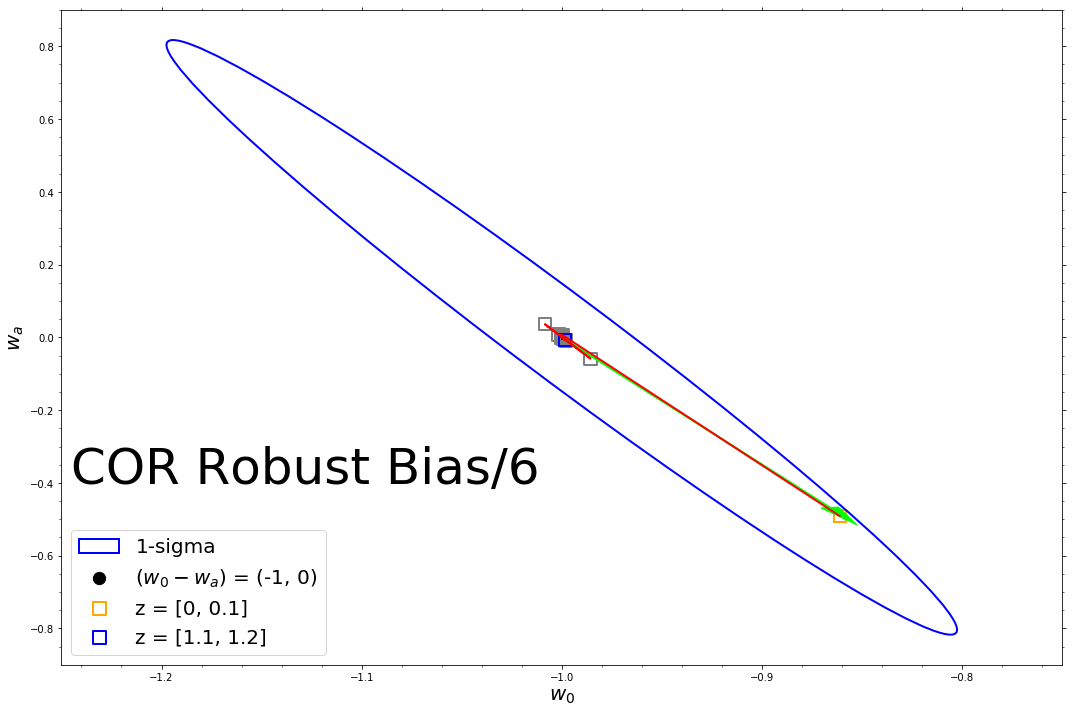

In [153]:
plt.rcParams['figure.figsize'] = [15,10] 
alpha = 1.52

params = par(F[2], F[3], F[4])
print ('Width : ', params[1])
print ('Height :', params[0])
print ('Angle :', -math.degrees(params[2]))



ell = mpl.patches.Ellipse(xy=[-1, 0], width=params[1], height=params[0], angle=-math.degrees(params[2]), facecolor='none', edgecolor='b', linewidth=2, label='1-sigma')
ell2 = copy(ell)
#ell = mpl.patches.Ellipse(xy=[-1, 0], width= 0.0696, height=1.679, angle=13.3949, facecolor='none', edgecolor='b', label='1-sigma')

fig, ax = plt.subplots()
ax.add_patch(ell)
ax.set_aspect('auto')
ax.set_facecolor('none')
ax.autoscale()  # ''tight
ax.scatter(F[1], F[0], c='black', marker='o',s=150, label='($w_0-w_a$) = (-1, 0)')
ax.set_xlabel(r'$w_0$',fontsize=20)
ax.set_ylabel(r'$w_a$',fontsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xlim(-1.25, -0.75)
ax.set_ylim(-0.9, 0.9)
ax.minorticks_on()
r = x.iloc[1:,:] # after first line
del_w0_1_all = x['del_w0'].iloc[0]    
del_wa_1_all = x['del_wa'].iloc[0] 

colors = ["red", "grey" , "grey", "grey", "grey","grey",'grey',"grey","grey","grey","grey","blue"]
del_w0_1 = r['del_w0']  
del_wa_1 = r['del_wa']  
x4 = [];y4=[];
for i in range(12):
    xxx = (del_w0_1.iloc[i]-1);yyy = del_wa_1.iloc[i] 
    x4.append(xxx);y4.append(yyy)
    plt.scatter(xxx,yyy,marker='s',facecolors='none',edgecolors=colors[i],s=150,linewidth=2)#label='%s'%(i+1)
    #rect = mpl.patches.Rectangle((xxx,yyy),.02,.06,linewidth=1,edgecolor='r',facecolor='none')
    #ax.add_patch(rect)
plt.plot(x4,y4,c='red',linewidth=2) 
plt.scatter(del_w0_1.iloc[0]-1, del_wa_1.iloc[0],marker='s',s=150,linewidth=2,edgecolors='orange',facecolors='none',label = 'z = [0, 0.1]' )
plt.scatter(del_w0_1.iloc[-1]-1, del_wa_1.iloc[-1],marker='s',s=150,linewidth=2,edgecolors='b',facecolors='none',label = 'z = [1.1, 1.2]' )
#a_all = plt.arrow(-1, 0, del_w0_1_all, del_wa_1_all, head_width=0.05, head_length=0.1,length_includes_head=True, color='lime')
a_all = plt.arrow(-1, 0, del_w0_1_all, del_wa_1_all, head_width=0.009, head_length=0.05,length_includes_head=True, color='lime')

#plt.text(-1.245, -0.4, 'CORIQRb', size=50)
plt.text(-1.245, -0.4, r'COR Robust Bias/6', size=50)
#plt.text(-1.245, -0.4, r'$\sigma$(Robust Bias)', size=50)
plt.legend(loc = 'lower left',prop={'size': 20})
'''
#------------------- Inset plot
left, bottom, width, height = [0.65, 0.7, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.add_patch(ell2)
ax2.set_aspect('auto')
ax2.set_facecolor('none')
ax2.autoscale()  # ''tight
ax2.scatter(F[1], F[0], c='black', marker='o',s=150, label='($w_0-w_a$) = (-1, 0)')
ax2.set_xlabel(r'$w_0$',fontsize=20)
ax2.set_ylabel(r'$w_a$',fontsize=20)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
#ax2.set_xlim(-1.025, -0.92)
#ax2.set_ylim(-0.3, 0.1)
ax2.minorticks_on()
for i in range(12):
    xxx = (del_w0_1.iloc[i]-1);yyy = del_wa_1.iloc[i] 
    x4.append(xxx);y4.append(yyy)
    plt.scatter(xxx,yyy,marker='s',facecolors='none',edgecolors=colors[i],s=150,linewidth=2)#label='%s'%(i+1)
    #rect = mpl.patches.Rectangle((xxx,yyy),.02,.06,linewidth=1,edgecolor='r',facecolor='none')
    #ax.add_patch(rect)
plt.plot(x4,y4,c='red',linewidth=1) 
plt.scatter(del_w0_1.iloc[0]-1, del_wa_1.iloc[0],marker='s',s=150,linewidth=2,edgecolors='orange',facecolors='none',label = 'z = [0, 0.1]' )
plt.scatter(del_w0_1.iloc[-1]-1, del_wa_1.iloc[-1],marker='s',s=150,linewidth=2,edgecolors='b',facecolors='none',label = 'z = [1.1, 1.2]' )
a_all = plt.arrow(-1, 0, del_w0_1_all, del_wa_1_all, head_width=0.007, head_length=0.03,length_includes_head=True, color='lime')
# head_width 0.05 , head_length = 0.1
'''

#plt.legend(loc = 'lower left')
plt.tight_layout()
#plt.savefig('new_CORIQRb1_sanity.pdf',bbox_inches='tight')

In [143]:
Not Used, Only Individual checks

apply = 11#int(sys.argv[2])-1  # which bin to apply with dz and omit the rest <<<<-----
print ('****** z - Bin to work on : ', apply+1)
counter = 0
z = np.linspace(0.05, 1.15, 12)
dm_dp = func()
sum = []
do_d1 = np.array(b.bias) 
cs1 = []
cs5 = []
cs6 = []
cols = ['bias', 'bin_used', 'how']
dat1 = pd.DataFrame(columns=cols)
dat5 = pd.DataFrame(columns=cols)
dat6 = pd.DataFrame(columns=cols)


#---------------------------------------------------------------
for i in (range(len(z))): # apply on all bins
    x1 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])
    cs1.append(x1)
dat1 = dat1.append({'bias': 'all_bias', 'bin_used': str(0), 'how': str(0)}, ignore_index=True)
#---------------------------------------------------------------
counter = 0
for i in (range(len(z))):  # APPLY ONLY ON ONE  BIN
    if apply == counter:
        #        print 'Condition match'
        #        print 'counter :',counter
        #        print 'apply :',apply
        x5 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])  # 
        bias_flag = b.bias[i]
    else:
        x5 = 0.#np.zeros(1)#del_m(i, do_d1[0][0], do_d1[0][1])
    counter += 1
    cs5.append(x5)
dat5 = dat5.append({'bias': str(bias_flag), 'bin_used': str(apply+1), 'how': str(1)}, ignore_index=True)
counter = 0
#---------------------------------------------------------------
for i in (range(len(z))):  # APPLY ON ALL BIN EXCEPT ONE
    #    print 'All BIn Except One : 6'
    if apply != counter:
        x6 = del_m(i)  + 1.4/(1+z[i])*(b.bias[i])  # 
        bias_flag = b.bias[i]
    else:
        x6 = 0.#np.zeros(1)
    counter += 1
    cs6.append(x6)
dat6 = dat6.append({'bias': str(bias_flag), 'bin_used': str(apply+1), 'how': str(11)}, ignore_index=True)
counter = 0
#---------------------------------------------------------------

option = '2'# ******************     <<<<-----
if option == '1': # all bin
    flag = cs1
    #print_d = do_d1[0]
    dat = dat1
elif option == '2':  # only one bin 
    flag = cs5
    #print_d = do_d1[1]
    dat = dat5    
elif option == '3':  # except one bin [0.01,0]
    flag = cs6
    #print_d = do_d1[1]
    dat = dat6        
#---------------------------------------------------------------    
del_m_sigma_sq = flag/sigma_sq  # cs1 is used
cov = covariance_matrix()
XX_om = 0.
XX_wa = 0.
XX_w0 = 0.0
XX_M = 0.
for n in range(len(dm_dp)):
    XX_om += dm_dp['dmdom'][n]*del_m_sigma_sq[n]
    XX_w0 += dm_dp['dmdwo'][n]*del_m_sigma_sq[n]
    XX_wa += dm_dp['dmdwa'][n]*del_m_sigma_sq[n]
    XX_M += dm_dp['dmdM'][n] * del_m_sigma_sq[n]
arr = [XX_M, XX_om, XX_w0, XX_wa]  
#--------------------------------------------------------------- 
del_p2 = cov.dot(arr)
columns = ['M', 'omegam', 'w0', 'wa']
delt = pd.DataFrame(columns=columns)
delt = delt.append({'M': del_p2[0], 'omegam':  del_p2[1],
                    'w0':  del_p2[2], 'wa':  del_p2[3]}, ignore_index=True)
#print ('\ndel_p2 (using d0,d1 = %s ): %s\n' % (print_d, del_p2))
data2 = pd.concat([delt, dat], axis=1)
name = 'del_p_LSST_CMBPrior_Stretch_%s.txt' % ide
name2 = 'del_p_LSST_CMBPrior_Stretch_LONG_%s.txt' % ide
np.savetxt(name, np.matrix(del_p2), fmt='%.4f')
#data2.to_csv(name2, index=False)

SyntaxError: invalid syntax (<ipython-input-143-58cd28f208bc>, line 1)

In [ ]:
plt.rcParams['figure.figsize'] = [15,10] 
alpha = 1.52
params = par(F[2], F[3], F[4])
print ('Width : ', params[1])
print ('Height :', params[0])
print ('Angle :', -math.degrees(params[2]))

ell = mpl.patches.Ellipse(xy=[-1, 0], width=params[1], height=params[0], angle=-
                          math.degrees(params[2]), facecolor='none', edgecolor='b', label='1-sigma')
fig, ax = plt.subplots()
ax.add_patch(ell)
ax.set_aspect('auto')
ax.set_facecolor('none')
ax.autoscale()  # ''tight
ax.scatter(F[1], F[0], c='black', marker='o', label='w0-wa')
ax.set_xlabel(r'$w_0$',fontsize=20)
ax.set_ylabel(r'$w_a$',fontsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xlim(-1.35, -0.75)
ax.set_ylim(-0.9, 0.9)
r = x.iloc[1:,:] # after first line
del_w0_1_all = x['del_w0'].iloc[0]    
del_wa_1_all = x['del_wa'].iloc[0] 

colors = ["red", "grey" , "grey", "grey", "grey","grey",'grey',"grey","","grey","grey","blue"]
del_w0_1 = r['del_w0']  
del_wa_1 = r['del_wa']  
x4 = [];y4=[];
for i in range(12):
    xxx = (del_w0_1.iloc[i]-1);yyy = del_wa_1.iloc[i] 
    x4.append(xxx);y4.append(yyy)
    plt.scatter(xxx,yyy,facecolors='none',edgecolors=colors[i],s=100)
    rect = mpl.patches.Rectangle((xxx,yyy),.02,.06,linewidth=1,edgecolor='r',facecolor='none')
    #ax.add_patch(rect)
plt.plot(x4,y4)    
a_all = plt.arrow(-1, 0, del_w0_1_all, del_wa_1_all, head_width=0.05, head_length=0.1,length_includes_head=True, color='lime')
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = [15,10] 
alpha = 1.52
params = par(F[2], F[3], F[4])
print ('Width : ', params[1])
print ('Height :', params[0])
print ('Angle :', -math.degrees(params[2]))

ell = mpl.patches.Ellipse(xy=[-1, 0], width=params[1], height=params[0], angle=-
                          math.degrees(params[2]), facecolor='none', edgecolor='b', label='1-sigma')

fig, ax = plt.subplots()
ax.add_patch(ell)
ax.set_aspect('auto')
ax.set_facecolor('none')
ax.autoscale()  # ''tight
ax.scatter(F[1], F[0], c='black', marker='o', label='w0-wa')
ax.set_xlabel('w_0')
ax.set_ylabel('w_a')
ax.tick_params(labeltop=True, labelright=True)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
